## Advanced Pipelining

Vanilla `pipeline` functionality applies the same transform to all the columns. We have argued that this was not enough:
* What if we have different data types? The transformers in question are designed mostly for a single type of data (e.g. scalers vs categoric variables). 
* What if we want to apply different pre-processing steps to same type of data? (e.g. log transform to count variables and keeping the others as is before scaling)
* What if we want to extract multiple types of features in parallel? (e.g. polynomial and radial basis for regression)?

We need to be able to apply different transformers to different columns (`ColumnTransformer`) and also be able to apply multiple transforms to a single column (`FeatureUnion`) in a single given step.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
import sklearn

Let's start with ColumnTransformer with a toy example:

In [2]:
from sklearn.compose import ColumnTransformer

In [3]:
data1 = np.column_stack((np.random.uniform(-2,1,5), np.random.randint(0,10,5)))
print(data1)

[[-0.79445445  9.        ]
 [ 0.67218726  3.        ]
 [ 0.61683194  2.        ]
 [-1.23004502  4.        ]
 [-1.16184231  6.        ]]


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
print(StandardScaler().fit_transform(data1))

[[-0.48863639  1.69222822]
 [ 1.23828382 -0.72524067]
 [ 1.17310484 -1.12815215]
 [-1.00152931 -0.32232919]
 [-0.92122296  0.48349378]]


In [6]:
print(MinMaxScaler().fit_transform(data1))

[[0.22898916 1.        ]
 [1.         0.14285714]
 [0.97089981 0.        ]
 [0.         0.28571429]
 [0.03585404 0.57142857]]


In [10]:
# Let's perform Z-normalization on the zeroth column and MinMaxScaling on the first
c0 = StandardScaler().fit_transform(data1[:,0:1]) #data1[:,0:1] vs data1[:,0] ?

In [11]:
c1 = MinMaxScaler().fit_transform(data1[:,1:])

In [12]:
print(np.column_stack((c0,c1)))

[[-0.48863639  1.        ]
 [ 1.23828382  0.14285714]
 [ 1.17310484  0.        ]
 [-1.00152931  0.28571429]
 [-0.92122296  0.57142857]]


In [13]:
ct = ColumnTransformer([ ('znorm', StandardScaler(), [0]), ('minmax', MinMaxScaler(), [1]) ])

In [14]:
data1ct =ct.fit_transform(data1)
print(data1ct)

[[-0.48863639  1.        ]
 [ 1.23828382  0.14285714]
 [ 1.17310484  0.        ]
 [-1.00152931  0.28571429]
 [-0.92122296  0.57142857]]


In [15]:
ct

ColumnTransformer(transformers=[('znorm', StandardScaler(), [0]),
                                ('minmax', MinMaxScaler(), [1])])

**What did we do?**  
We specified the name and type of the transformers and the columns that they should affect. It is your turn, let's do something similar below

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

In [17]:
data2 = [[0.5, 1.2, -2.3, -0.7, 3.7],
         ['a', 'b', None, 'b', 'c']]

In [18]:
y = [0, 1, 0, 0, 1]

In [19]:
# Put these into a pandas dataframe. Note that the rows of data2 should be the columns of the data!

df = pd.DataFrame(data2)
display(df)

,0,1,2,3,4
0,0.5,1.2,-2.3,-0.7,3.7
1,a,b,NaN,b,c


In [20]:
df = df.T
display(df)

,0,1
0,0.5,a
1,1.2,b
2,-2.3,NaN
3,-0.7,b
4,3.7,c


In [21]:
# Perform z-normalization on the first column
# Perform most frequent imputation to the second column followed by one-hot encoding. 
# Hint: ColumnTransformers can be used in a Pipeline and Pipelines can be used in ColumnTransformers 
#SimpleImputer + OneHotEncoder Pipeline
pp_pipe = Pipeline([('imp',SimpleImputer(strategy = "most_frequent")), 
                    ('ohe', OneHotEncoder(handle_unknown = "ignore"))])

In [25]:
#display(pp_pipe.fit_transform(df.iloc[:,1:]).toarray())

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [23]:
display(pp_pipe.fit_transform(df.iloc[:,1:]).todense())

matrix([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [26]:
#ct = ColumnTransformer([ ('znorm', StandardScaler(), [0]), ('minmax', MinMaxScaler(),[1]) ])
ct = ColumnTransformer([ ('znorm', StandardScaler(), [0]), ('pipe', pp_pipe, [1]) ])

In [27]:
display(ct.fit_transform(df))

array([[ 0.009998  ,  1.        ,  0.        ,  0.        ],
       [ 0.35992802,  0.        ,  1.        ,  0.        ],
       [-1.38972208,  0.        ,  1.        ,  0.        ],
       [-0.58988204,  0.        ,  1.        ,  0.        ],
       [ 1.6096781 ,  0.        ,  0.        ,  1.        ]])

In [28]:
# Fit a decision tree classifier 
#dt = DecisionTreeClassifier().fit(ct.fit_transform(df))

#something.fit(df, y)
main_pipe = Pipeline([('pp_all',ct), ('dt_classifier', DecisionTreeClassifier())])
main_pipe.fit(df, y)
print(main_pipe.score(df,y))

1.0


In [29]:
main_pipe

Pipeline(steps=[('pp_all',
                 ColumnTransformer(transformers=[('znorm', StandardScaler(),
                                                  [0]),
                                                 ('pipe',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [1])])),
                ('dt_classifier', DecisionTreeClassifier())])

In [30]:
df

,0,1
0,0.5,a
1,1.2,b
2,-2.3,NaN
3,-0.7,b
4,3.7,c


In [31]:
np.arange(df.shape[1])

array([0, 1])

In [32]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [33]:
cv = StratifiedKFold(n_splits = 2 ,shuffle=True)

In [34]:
params_to_search = {'dt_classifier__max_depth':[2,3,4,None]}

In [35]:
gs = GridSearchCV(estimator = main_pipe, param_grid = params_to_search, cv = cv)

In [38]:
gs.fit(df,y)
gs.score(df,y)

1.0

Detour: Python Slice Feature  
`slice(start,stop,step)`

In [39]:
tmp = np.arange(10)
print(tmp)
print(tmp[slice(3)], tmp[:3])
print(tmp[slice(3,7)], tmp[3:7])
print(tmp[slice(1,7,2)], tmp[1:7:2])

[0 1 2 3 4 5 6 7 8 9]
[0 1 2] [0 1 2]
[3 4 5 6] [3 4 5 6]
[1 3 5] [1 3 5]


What if we had more columns that we do not want to touch or where it is impractical to list all?

In [40]:
np.set_printoptions(precision=3, suppress = True)

In [43]:
data3 = np.random.random((15,10))

In [44]:
pp1 = StandardScaler()
pp2 = MinMaxScaler((-1,0))

In [45]:
ct_more1 = ColumnTransformer([('znorm', pp1, [0,1]), ('minmax',pp2, slice(3,7))])

In [46]:
data3ct1 = ct_more1.fit_transform(data3)

In [47]:
print(data3ct1.shape)
print(data3ct1.mean(axis=0))
print(data3ct1.std(axis=0))
print(data3ct1.min(axis=0))
print(data3ct1.max(axis=0))

(15, 6)
[ 0.    -0.    -0.367 -0.481 -0.548 -0.394]
[1.    1.    0.306 0.288 0.271 0.286]
[-1.629 -1.884 -1.    -1.    -1.    -1.   ]
[2.107 1.703 0.    0.    0.    0.   ]


What to do with the remaining columns?
* Drop them (defautl behavior)
* Pass them as is
* Apply another transformer

In [48]:
ct_more2 = ColumnTransformer([('znorm', pp1, [0,1]), ('minmax',pp2, slice(3,7))], remainder='passthrough')

data3ct2 = ct_more2.fit_transform(data3)
print(data3ct2.shape)
print(data3ct2.mean(axis=0))
print(data3ct2.std(axis=0))
print(data3ct2.min(axis=0))
print(data3ct2.max(axis=0))

(15, 10)
[ 0.    -0.    -0.367 -0.481 -0.548 -0.394  0.652  0.52   0.527  0.667]
[1.    1.    0.306 0.288 0.271 0.286 0.256 0.308 0.29  0.259]
[-1.629 -1.884 -1.    -1.    -1.    -1.     0.143  0.004  0.065  0.209]
[2.107 1.703 0.    0.    0.    0.    0.949 0.992 0.955 0.982]


In [49]:
ct_more3 = ColumnTransformer([('znorm', pp1, [0,1]), ('minmax',pp2, slice(3,7))], remainder=MinMaxScaler((1,2)))

data3ct3 = ct_more3.fit_transform(data3)
print(data3ct3.shape)
print(data3ct3.mean(axis=0))
print(data3ct3.std(axis=0))
print(data3ct3.min(axis=0))
print(data3ct3.max(axis=0))

(15, 10)
[ 0.    -0.    -0.367 -0.481 -0.548 -0.394  1.632  1.522  1.519  1.592]
[1.    1.    0.306 0.288 0.271 0.286 0.317 0.312 0.326 0.335]
[-1.629 -1.884 -1.    -1.    -1.    -1.     1.     1.     1.     1.   ]
[2.107 1.703 0.    0.    0.    0.    2.    2.    2.    2.   ]


In [50]:
ct_more4 = ColumnTransformer([('znorm', pp1, [0,1]), ('dropped','drop', slice(3,7))], remainder=MinMaxScaler((1,2)))

data3ct4 = ct_more4.fit_transform(data3)
print(data3ct4.shape)

(15, 6)


In [51]:
#Keeping the ordering
ct_more5 = ColumnTransformer([('znorm', pp1, [0,1]),  
                              ('keep','passthrough',[2]), 
                              ('minmax',pp2, slice(3,6))], 
                             remainder=MinMaxScaler((1,2)))

data3ct5 = ct_more5.fit_transform(data3)
print(data3ct5.shape)
print(data3ct5.mean(axis=0))
print(data3ct5.std(axis=0))
print(data3ct5.min(axis=0))
print(data3ct5.max(axis=0))

(15, 10)
[ 0.    -0.     0.652 -0.367 -0.481 -0.548  1.606  1.522  1.519  1.592]
[1.    1.    0.256 0.306 0.288 0.271 0.286 0.312 0.326 0.335]
[-1.629 -1.884  0.143 -1.    -1.    -1.     1.     1.     1.     1.   ]
[2.107 1.703 0.949 0.    0.    0.    2.    2.    2.    2.   ]


If the input is a pandas DataFrame, we can use the column names (in the first level) as well!

In [54]:
df = pd.DataFrame(data2).T
df

,0,1
0,0.5,a
1,1.2,b
2,-2.3,NaN
3,-0.7,b
4,3.7,c


In [55]:
df = df.rename({0:'numbers',1:'categories'},axis=1)
df

,numbers,categories
0,0.5,a
1,1.2,b
2,-2.3,NaN
3,-0.7,b
4,3.7,c


In [56]:
cat_pipe = Pipeline(steps = [('imp',SimpleImputer(strategy='most_frequent')),('enc',OneHotEncoder())])

In [57]:
ct_nodf = ColumnTransformer([('znorm',StandardScaler(),[0]),('cat', cat_pipe,[1])])

In [58]:
ct_nodf.fit_transform(df)

array([[ 0.01,  1.  ,  0.  ,  0.  ],
       [ 0.36,  0.  ,  1.  ,  0.  ],
       [-1.39,  0.  ,  1.  ,  0.  ],
       [-0.59,  0.  ,  1.  ,  0.  ],
       [ 1.61,  0.  ,  0.  ,  1.  ]])

In [59]:
cat_pipe = Pipeline(steps = [('imp',SimpleImputer(strategy='most_frequent')),('enc',OneHotEncoder())])

In [60]:
ct_df = ColumnTransformer([('znorm',StandardScaler(),['numbers']),('cat', cat_pipe,['categories'])])
ct_df.fit_transform(df)

array([[ 0.01,  1.  ,  0.  ,  0.  ],
       [ 0.36,  0.  ,  1.  ,  0.  ],
       [-1.39,  0.  ,  1.  ,  0.  ],
       [-0.59,  0.  ,  1.  ,  0.  ],
       [ 1.61,  0.  ,  0.  ,  1.  ]])

The returned object is a numpy array and not a data frame and as such we are losing information What happens if we want to apply more preprocessing steps after this? Do we have to know the number of categories for each categorical feature to align stuff after one hot encoding? What is we decide to drop or pass through features? 

Unfortunately, there is no generic solution other than the manual one. This is done by following the ColumnTransformer documentation:

> The order of the columns in the transformed feature matrix follows the order of how the columns are specified in the transformers list. Columns of the original feature matrix that are not specified are dropped from the resulting transformed feature matrix, unless specified in the passthrough keyword. Those columns specified with passthrough are added at the right to the output of the transformers.

However, there are a few tricks you can do which we will skip for now (an interesting [example](https://stackoverflow.com/questions/57528350/can-you-consistently-keep-track-of-column-labels-using-sklearns-transformer-api/57534118#57534118) from Stack Overflow for the interested )

In [62]:
# Uncomment and see if this runs for your scikit-learn version
#ct_df.get_feature_names()

Let's do a more complicated example but still with a toy dataset.

In [63]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [64]:
# You need an internet connection
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# If the above doesn't work (loads it but with different column names)
#from catboost.datasets import titanic
#X, y = titanic()

display(X)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,None,C,None,328.0,None
1305,3.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,None,C,None,NaN,None
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,None,C,None,304.0,None
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,None,C,None,NaN,None


In [65]:
y

0       1
1       1
2       0
3       0
4       0
       ..
1304    0
1305    0
1306    0
1307    0
1308    0
Name: survived, Length: 1309, dtype: category
Categories (2, object): ['0', '1']

Features:
* sibsp: Number of Siblings/Spouses Aboard
* parch: Number of Parents/Children Aboard
* survival - Survival (0 = No; 1 = Yes)
* pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* ticket - Ticket Number
* fare - Passenger Fare
* cabin - Cabin
* embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
* boat - Lifeboat (if survived)
* body - Body number (if did not survive and body was recovered)

In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
dtypes: category(2), float64(6), object(5)
memory usage: 115.4+ KB


In [67]:
X.describe()

,pclass,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [68]:
X.describe(include=object)

,name,ticket,cabin,boat,home.dest
count,1309,1309,295,486,745
unique,1307,929,186,27,369
top,"Connolly, Miss. Kate",CA. 2343,C23 C25 C27,13,"New York, NY"
freq,2,11,6,39,64


In [69]:
X.describe(include='category')

,sex,embarked
count,1309,1307
unique,2,3
top,male,S
freq,843,914


What should we do?
* Drop `name`, `ticket`, `boat`, `home.dest`, `cabin` and `body` (some of them e.g. cabin would be useful but we are making it easier) 
* `pclass`: Ordinal, may stay as is or may be treated as a categorical value
* `sex`: To binary
* `age` and `fare`: Standard scaler
* `sibsp` and `parch`: log1p (count values) and perhaps maxabsolute scaler (lots of 0s) 
* `embarked`: One-Hot 

These are the initial ideas, let's look at the data and see

In [70]:
X = X.drop(['name','ticket','boat','home.dest','cabin','body'],axis=1)

<AxesSubplot:>

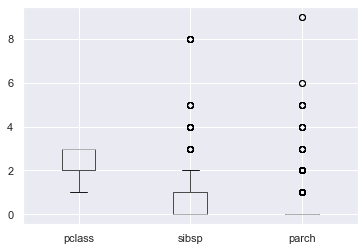

In [71]:
X.drop(['age','fare'],axis=1).boxplot()

{'whiskers': [<matplotlib.lines.Line2D at 0x19a5ccfd730>,
 'caps': [<matplotlib.lines.Line2D at 0x19a5ccfdcd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x19a5ccfd460>],
 'medians': [<matplotlib.lines.Line2D at 0x19a5cd0b2b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x19a5cd0b580>],
 'means': []}

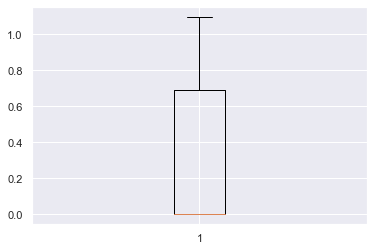

In [72]:
plt.boxplot(np.log1p(X['pclass'].max()-X['pclass']))

{'whiskers': [<matplotlib.lines.Line2D at 0x19a5cd5c9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x19a5cd5cf70>,
 'boxes': [<matplotlib.lines.Line2D at 0x19a5cd5c700>],
 'medians': [<matplotlib.lines.Line2D at 0x19a5cd6a550>],
 'fliers': [<matplotlib.lines.Line2D at 0x19a5cd6a820>],
 'means': []}

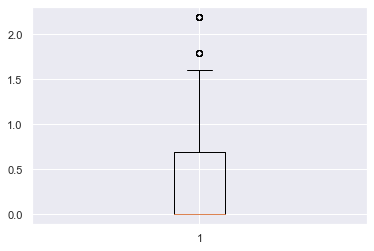

In [73]:
plt.boxplot(np.log1p(X['sibsp']))

{'whiskers': [<matplotlib.lines.Line2D at 0x19a5cdb88b0>,
 'caps': [<matplotlib.lines.Line2D at 0x19a5cdb8e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x19a5cdb85e0>],
 'medians': [<matplotlib.lines.Line2D at 0x19a5cdc6430>],
 'fliers': [<matplotlib.lines.Line2D at 0x19a5cdc6700>],
 'means': []}

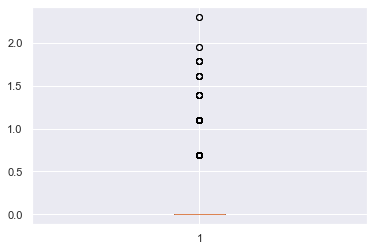

In [74]:
plt.boxplot(np.log1p(X['parch']))

(array([ 72.,  62., 274., 250., 161., 108.,  65.,  41.,  10.,   3.]),
 array([ 0.167,  8.15 , 16.133, 24.117, 32.1  , 40.083, 48.067, 56.05 ,
        64.033, 72.017, 80.   ]),
 <BarContainer object of 10 artists>)

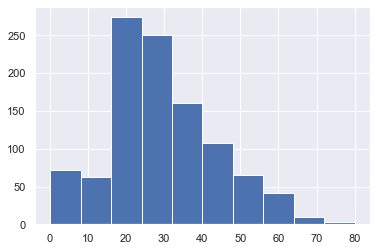

In [75]:
plt.hist(X['age'])

(array([  7.,  15.,  19.,  15.,  16.,  27., 191., 393., 282.,  81.]),
 array([0.154, 0.578, 1.002, 1.426, 1.85 , 2.274, 2.698, 3.122, 3.546,
        3.97 , 4.394]),
 <BarContainer object of 10 artists>)

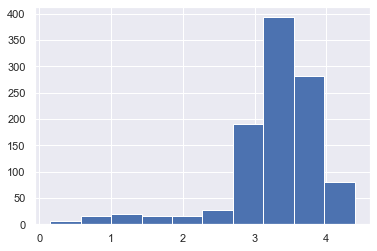

In [76]:
plt.hist((np.log1p(X['age'])))

(array([1070.,  154.,   42.,    4.,   21.,   13.,    0.,    0.,    0.,
           4.]),
 array([  0.   ,  51.233, 102.466, 153.699, 204.932, 256.165, 307.398,
        358.63 , 409.863, 461.096, 512.329]),
 <BarContainer object of 10 artists>)

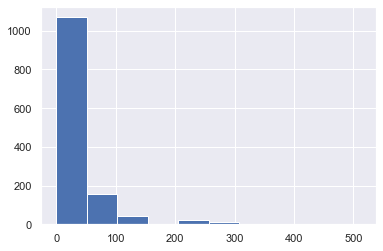

In [77]:
plt.hist(X['fare'])

(array([ 17.,   0.,   3., 514., 250., 261., 129.,  80.,  50.,   4.]),
 array([0.   , 0.624, 1.248, 1.872, 2.496, 3.12 , 3.745, 4.369, 4.993,
        5.617, 6.241]),
 <BarContainer object of 10 artists>)

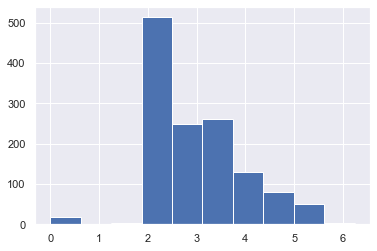

In [78]:
plt.hist((np.log1p(X['fare'])))

<AxesSubplot:xlabel='embarked', ylabel='count'>

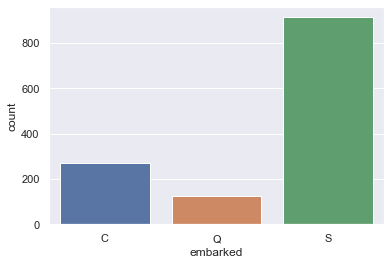

In [81]:
sns.countplot(x=X['embarked'])

<AxesSubplot:xlabel='sex', ylabel='count'>

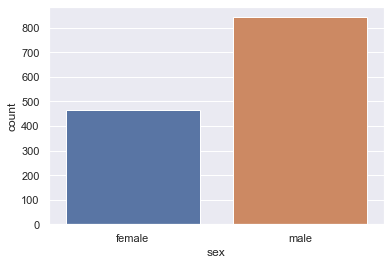

In [82]:
sns.countplot(X['sex'])

<AxesSubplot:xlabel='survived', ylabel='count'>

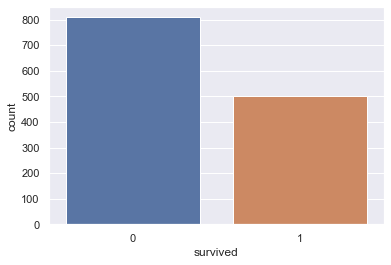

In [83]:
sns.countplot(y)

In [84]:
# Missing data counts
X.isnull().sum()

pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

**At Home Exercise:** Look at survival statistics based on sex, age, fare, pclass etc. 

<AxesSubplot:xlabel='survived', ylabel='count'>

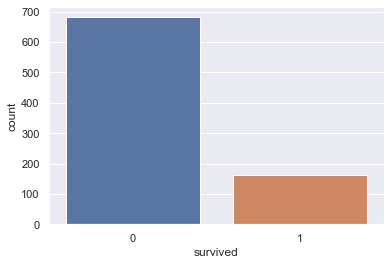

In [85]:
ez_df = X.copy()
ez_df['survived'] = y

sns.countplot(ez_df[ez_df['sex']=='male']['survived'])

<AxesSubplot:xlabel='survived', ylabel='count'>

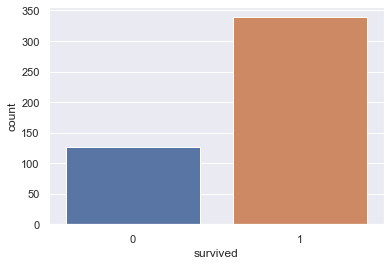

In [86]:
sns.countplot(ez_df[ez_df['sex']=='female']['survived'])

In [87]:
baseline_accuracy = ((ez_df[ez_df['sex']=='female']['survived']=='1').sum()+(ez_df[ez_df['sex']=='male']['survived']=='0').sum())/1309
print(baseline_accuracy)

0.7799847211611918


<AxesSubplot:xlabel='survived', ylabel='count'>

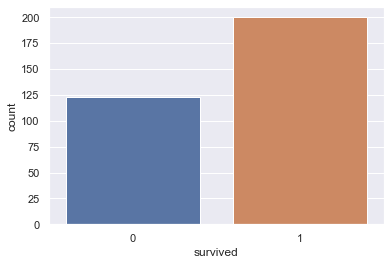

In [88]:
sns.countplot(ez_df[ez_df['pclass']==1]['survived'])

<AxesSubplot:xlabel='survived', ylabel='count'>

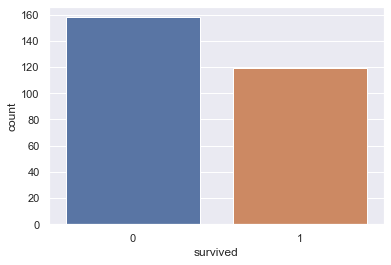

In [89]:
sns.countplot(ez_df[ez_df['pclass']==2]['survived'])

<AxesSubplot:xlabel='survived', ylabel='count'>

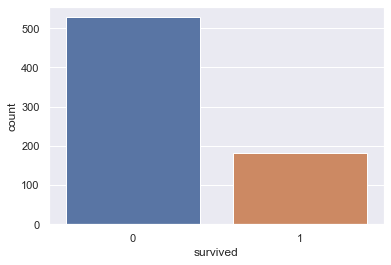

In [90]:
sns.countplot(ez_df[ez_df['pclass']==3]['survived'])

<AxesSubplot:xlabel='survived', ylabel='count'>

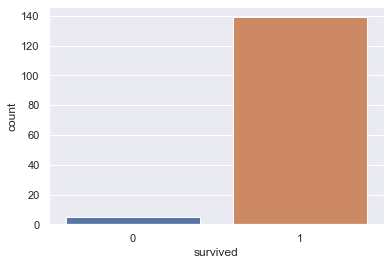

In [91]:
sns.countplot(ez_df[(ez_df['pclass']==1) & (ez_df['sex']=='female')]['survived'])

<AxesSubplot:xlabel='survived', ylabel='count'>

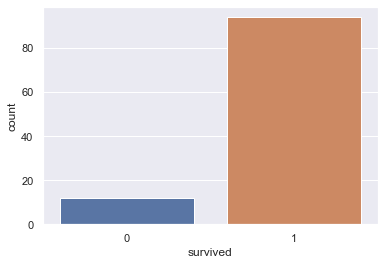

In [92]:
sns.countplot(ez_df[(ez_df['pclass']==2) & (ez_df['sex']=='female')]['survived'])

<AxesSubplot:xlabel='survived', ylabel='count'>

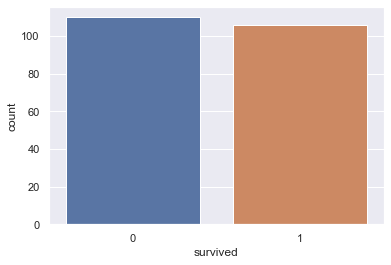

In [93]:
sns.countplot(ez_df[(ez_df['pclass']==3) & (ez_df['sex']=='female')]['survived'])

The suggested steps (we can change it during the lecture!)

**Lvl 1:**
* sex: to binary, labelencoder is fine
* embarked: missing value as the most frequent port (since we do not have many missing values)
* embarked: to-one-hot

**Lvl 2:**
* overall iterative imputation with random forest regressor

**Lvl 3:**
* pclass: leave as is or min max scaler
* sibsp and parch: log(1+x) (but we could easily remove parch)
* age: standard scaling
* fare: log(1+x) then standard scaling

**Classifier:** Compare Random Forest, SVM and LogisticRegression

(Note: This may not be the best order :))

Let's focus on the usage of pipelines and column transformers instead of the final accuracy for now:

In [101]:
# The first step
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y)

In [94]:
from sklearn.metrics import accuracy_score

def test(clf, Xtrain, Xtest, ytrain, ytest, name = None, refit = True):
    if refit:
        clf.fit(Xtrain, ytrain)
    ytrainPred = clf.predict(Xtrain)
    ytestPred = clf.predict(Xtest)
    if name:
        print(name)
    else:
        print(clf.steps[1][0])
    print('Train:',accuracy_score(ytrain,ytrainPred))
    print('Test:',accuracy_score(ytest,ytestPred))

In [95]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [97]:
# Needed since LabelEncoder does not play nicely with pipelines
from sklearn.preprocessing import LabelEncoder

class PipelineLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        X = np.empty(y.shape)
        df = False
        if type(y) == pd.DataFrame:
            df = True
        for i in range(y.shape[1]):
            if df:
                X[:,i] = super().fit_transform(y.iloc[:,i])
            else:
                X[:,i] = super().fit_transform(y[:,i])
        return X

    def transform(self, y, *args, **kwargs):
        X = np.empty(y.shape)
        df = False
        if type(y) == pd.DataFrame:
            df = True
        for i in range(y.shape[1]):
            if df:
                X[:,i] = super().transform(y.iloc[:,i])
            else:
                X[:,i] = super().transform(y[:,i])
        return X

In [98]:
# Baseline based on the EDA: Decision Tree CLassifier on just the sex and pclass
# Need to convert sex to binary
dt_ct = ColumnTransformer([('lenc',PipelineLabelEncoder(),['sex']),('pt','passthrough',['pclass'])],remainder='drop')

In [99]:
dt_pipe = Pipeline([('preprocesser',dt_ct),('dt_classifier', DecisionTreeClassifier())])

In [103]:
dt_pipe

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('lenc',
                                                  PipelineLabelEncoder(),
                                                  ['sex']),
                                                 ('pt', 'passthrough',
                                                  ['pclass'])])),
                ('dt_classifier', DecisionTreeClassifier())])

In [102]:
test(dt_pipe, Xtrain, Xtest, ytrain, ytest, name = 'Decision Tree', refit = True)

Decision Tree
Train: 0.7745940783190067
Test: 0.8015267175572519


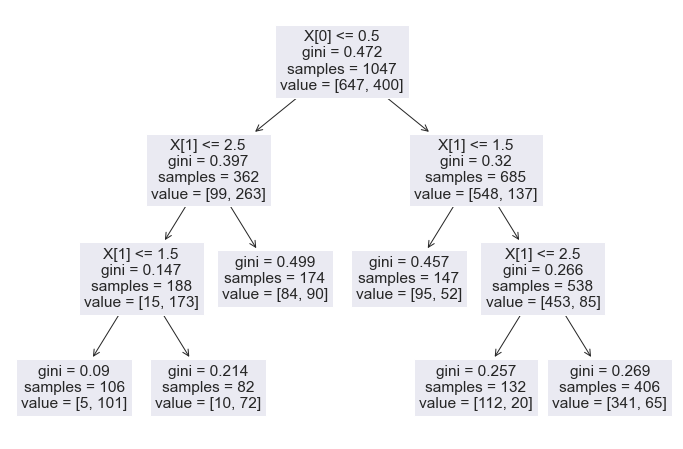

In [104]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12,8))
plot_tree(dt_pipe.named_steps['dt_classifier'])
plt.show()

In [105]:
Xtrain.shape

(1047, 7)

In [106]:
Xtrain.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'], dtype='object')

In [107]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
"""
**Lvl 1:**
* sex: to binary, labelencoder is fine
* embarked: missing value as the most frequent port (since we do not have many missing values)
* embarked: to-one-hot
"""

In [108]:
genderLenc = ('GenderLabelEncoder', PipelineLabelEncoder(), ['sex'])

In [110]:
genderLenc2 = ('GenderLabelEncoder', LabelEncoder(), ['sex'])

In [111]:
embarkedInit = ('EmbarkedInit', 
                Pipeline([('EmbarkedImpute', SimpleImputer(strategy='most_frequent')),
                          ('EmbarkedOneHot',OneHotEncoder(handle_unknown='ignore'))]),  ['embarked'])

In [112]:
# passthrough changes the order. Furthermore we lose the pandas dataframe. After this, 
# we will need to keep track of the indices. This is a trade-off of scikit-learn where they 
# value numpy array compatibility over pandas dataframe compatibility but work is being done

# order before: pclass, sex, age, sibsp, parch, fare, embarked
# order after the below: sex, embarked x 3 (1 hot), pclass, age, sibsp, parch, fare
firstLevelCT = ColumnTransformer([genderLenc, embarkedInit], remainder='passthrough')

In [117]:
"""
**Lvl 2:**
* overall iterative imputation
"""

'\n**Lvl 2:**\n* overall iterative imputation\n'

In [118]:
# order after the below: sex, embarked x 3 (1hot), pclass, age, sibsp, parch, fare, i.e., no change
#allImputer = ('AllImpute', 
#               IterativeImputer(estimator=RandomForestRegressor(n_estimators=50), max_iter=10, tol=0.01), 
#               np.arange(9))
#secondLevelCT = ColumnTransformer([allImputer])
secondLevel = Pipeline([('AllImpute',IterativeImputer(estimator=RandomForestRegressor(n_estimators=50), 
                                                      max_iter=10, 
                                                      tol=0.01))])

In [ ]:
"""
**Lvl 3:**
* pclass: leave as is or min max scaler
* sibsp: log(1+x)
* parch: drop
* age: standard scaling
* fare: log(1+x) then standard scaling
"""

In [119]:
Log1pTransformer = FunctionTransformer(np.log1p, validate=True)
sibsp = ('CountsLogT', Log1pTransformer, [6])
parch = ('Drop','drop',[7])
ageScaler = ('AgeScaler', StandardScaler(), [5])
fare = ('Fare', Pipeline([('FareLT',Log1pTransformer), ('FareSc',StandardScaler())]), [8])

In [121]:
# order after the below: sibsp, parch, age, fare, sex, embarked x 3 (1hot), pclass
thirdLevelCT = ColumnTransformer([sibsp,parch,ageScaler,fare], remainder='passthrough')

In [122]:
MainPipeLine = Pipeline ([('first', firstLevelCT),
                          ('second', secondLevel),
                          ('third', thirdLevelCT)]) 

In [123]:
x1 = firstLevelCT.fit_transform(Xtrain)

In [124]:
print(x1.shape)

(1047, 9)


In [125]:
print(x1)

[[ 1.     0.     0.    ...  0.     0.     7.775]
 [ 1.     0.     0.    ...  0.     0.     7.55 ]
 [ 1.     1.     0.    ...  0.     0.     8.662]
 ...
 [ 0.     0.     0.    ...  0.     4.    25.467]
 [ 1.     0.     0.    ...  0.     0.    13.   ]
 [ 0.     0.     0.    ...  0.     0.     8.05 ]]


In [126]:
x2 = secondLevel.fit_transform(x1)
x3 = thirdLevelCT.fit_transform(x2)

print(x1.shape,x2.shape,x3.shape)

(1047, 9) (1047, 9) (1047, 8)


In [127]:
x123 = MainPipeLine.fit_transform(Xtrain)
print(x123.shape)
print((x3-x123).sum(axis=1))

# Discrepancy is due to RandomForestRegressor imputation since it introduces some randomness

(1047, 8)
[ 0.001  0.001  0.001 ... -0.313  0.     0.002]


In [128]:
LrPipeline  = Pipeline([('main', MainPipeLine), ('lr',  LogisticRegression())])
SvmPipeline = Pipeline([('main', MainPipeLine), ('svm', SVC())])
RfPipeline  = Pipeline([('main', MainPipeLine), ('rf',  RandomForestClassifier())])

In [129]:
# Warning:: MainPipeLine is fitted each time and our iterative imputer is a bit expensive

In [130]:
test(LrPipeline, Xtrain, Xtest, ytrain, ytest)

lr
Train: 0.7936962750716332
Test: 0.7938931297709924


In [131]:
test(SvmPipeline, Xtrain, Xtest, ytrain, ytest)

svm
Train: 0.8003820439350525
Test: 0.8206106870229007


In [132]:
test(RfPipeline, Xtrain, Xtest, ytrain, ytest)

rf
Train: 0.9713467048710601
Test: 0.816793893129771


In [133]:
# Faster Alternative if the preprocessing steps are the same:
XtrainPreProc = MainPipeLine.fit_transform(Xtrain)
XtestPreProc = MainPipeLine.transform(Xtest)

# Then call the LogisticRegression, SVC and RandomForestClassifier fit using XtrainPreProc
dt2 = DecisionTreeClassifier()

dt2.fit(XtrainPreProc, ytrain)
ytrainDt = dt2.predict(XtrainPreProc)
ytestDt = dt2.predict(XtestPreProc)
print('Train:',accuracy_score(ytrain,ytrainDt))
print('Test:',accuracy_score(ytest,ytestDt))

#Worse than the first baseline??

Train: 0.9713467048710601
Test: 0.7900763358778626


What about hyper parameter search?

In [134]:
LrPipeline.steps[0][1].steps

[('first',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('GenderLabelEncoder', PipelineLabelEncoder(),
                                   ['sex']),
                                  ('EmbarkedInit',
                                   Pipeline(steps=[('EmbarkedImpute',
                                                    SimpleImputer(strategy='most_frequent')),
                                                   ('EmbarkedOneHot',
                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                   ['embarked'])])),
 ('second',
  Pipeline(steps=[('AllImpute',
                   IterativeImputer(estimator=RandomForestRegressor(n_estimators=50),
                                    tol=0.01))])),
 ('third',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('CountsLogT',
                                   FunctionTransformer(func=<ufunc 'log1p'>,
                      

In [135]:
from sklearn.model_selection import StratifiedKFold
# With grid search, does not change the result all that much
cv = StratifiedKFold(n_splits=3, shuffle=True)

param_grid = {'main__second__AllImpute__estimator__n_estimators': [25,50,100],
              'lr__C':[1,5,10]}

gsLr = GridSearchCV(LrPipeline, param_grid, cv = cv)
test(gsLr, Xtrain, Xtest, ytrain, ytest,'lr with grid')

C:\Users\Hamza\anaconda3\envs\aima\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Hamza\anaconda3\envs\aima\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Hamza\anaconda3\envs\aima\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Hamza\anaconda3\envs\aima\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Hamza\anaconda3\envs\aima\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Hamza\anaconda3\envs\aima\lib\site-packages\sklearn\impute\_iterative.py:699: Converge

lr with grid
Train: 0.7946513849092646
Test: 0.7977099236641222


C:\Users\Hamza\anaconda3\envs\aima\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# Try the other pipelines at home


Let's switch to FeatureUnion with a familiar data

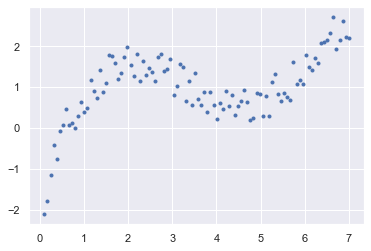

In [136]:
# Familiar data
xP = np.linspace(0.1,7,100)    

#Adding uniform noise
yP = np.log(xP) + np.sin(xP) + np.random.uniform(-0.5,0.5,len(xP))

yGT = np.log(xP) + np.sin(xP)
             
XP = xP[:,np.newaxis]

plt.plot(xP, yP,'.')

In [137]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [159]:
stepsPoly = [('poly', PolynomialFeatures(4)), 
             ('lr', LinearRegression()) ]

In [160]:
pipePoly = Pipeline(stepsPoly)

In [161]:
pipePoly.fit(XP,yP)

Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                ('lr', LinearRegression())])

In [162]:
yPredP = pipePoly.predict(XP)

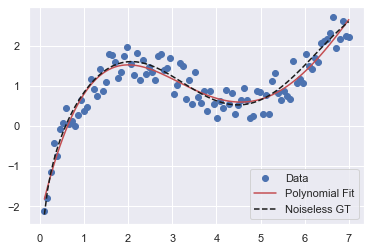

In [163]:
plt.scatter(xP,yP)
plt.plot(xP,yPredP,'r')
plt.plot(xP,yGT,'k--')
plt.legend(['Data','Polynomial Fit','Noiseless GT'])
#plt.legend(['Polynomial Fit','Noiseless GT','Data'])
plt.show()

In [164]:
pipePoly.named_steps['lr'].coef_

array([ 0.   ,  4.77 , -1.977,  0.3  , -0.014])

In [165]:
a = PolynomialFeatures(3)
a.fit_transform(XP).shape

(100, 4)

In [166]:
a.transform([[1],[2],[3]])

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.]])

In [167]:
# What if we want to add more features?

from sklearn.pipeline import FeatureUnion

In [168]:
featUn = FeatureUnion([('poly', PolynomialFeatures(3)),
                       ('log', FunctionTransformer(np.log))])

In [169]:
featUn.fit_transform(XP).shape

(100, 5)

In [170]:
featUn.transform([[1],[2],[3]])

array([[ 1.   ,  1.   ,  1.   ,  1.   ,  0.   ],
       [ 1.   ,  2.   ,  4.   ,  8.   ,  0.693],
       [ 1.   ,  3.   ,  9.   , 27.   ,  1.099]])

In [171]:
stepsfeatUn = [('featUn', featUn), 
               ('lr', LinearRegression()) ]

In [172]:
pipefeatUn = Pipeline(stepsfeatUn)

In [173]:
pipefeatUn.fit(XP,yP)

Pipeline(steps=[('featUn',
                 FeatureUnion(transformer_list=[('poly',
                                                 PolynomialFeatures(degree=3)),
                                                ('log',
                                                 FunctionTransformer(func=<ufunc 'log'>))])),
                ('lr', LinearRegression())])

In [174]:
yPredF = pipefeatUn.predict(XP)

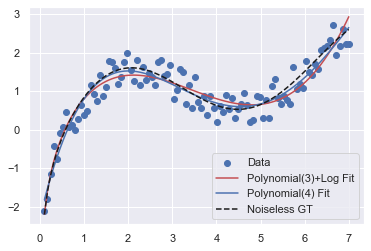

In [176]:
plt.scatter(xP,yP)
plt.plot(xP,yPredF,'r')
plt.plot(xP,yPredP,'b')
plt.plot(xP,yGT,'k--')
plt.legend(['Data','Polynomial(3)+Log Fit','Polynomial(4) Fit','Noiseless GT'])
plt.show()

In [177]:
featUn2 = FeatureUnion([('sin', FunctionTransformer(np.sin)),
                        ('log', FunctionTransformer(np.log))])

In [178]:
stepsfeatUn2 = [('featUn', featUn2), 
                ('lr', LinearRegression()) ]

In [179]:
pipefeatUn2 = Pipeline(stepsfeatUn2)

In [180]:
pipefeatUn2.fit(XP,yP)
yPredF2 = pipefeatUn2.predict(XP)

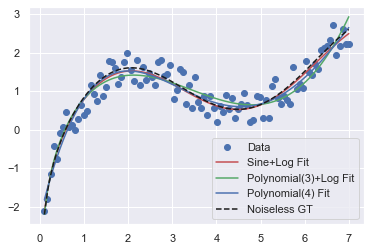

In [182]:
plt.scatter(xP,yP)
plt.plot(xP,yPredF2,'r')
plt.plot(xP,yPredF,'g')
plt.plot(xP,yPredP,'b')
plt.plot(xP,yGT,'k--')
plt.legend(['Data','Sine+Log Fit','Polynomial(3)+Log Fit','Polynomial(4) Fit','Noiseless GT'])
plt.show()


In [183]:
featUn2.transform([[1],[2],[3]])

array([[0.841, 0.   ],
       [0.909, 0.693],
       [0.141, 1.099]])

In [185]:
pipefeatUn2.named_steps['lr'].coef_

array([0.945, 0.967])

In [186]:
pipefeatUn.named_steps['lr'].coef_

array([ 0.   ,  1.496, -0.687,  0.071,  0.981])

There was a suggestion in the regression part of the lecture, why don't we combine multiple features and do feature selection with Lasso regression? Let's do this!

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:


# We are now extending the required classes
class GaussianRbfFeaturesPipeline(BaseEstimator,TransformerMixin):
    def __init__(self, num_centers=10, width_constant=1.0):
        #We set the centers and widths automatically
        self.k = num_centers
        self.h = width_constant
    
    @staticmethod
    def _rbf(x,c,h):
        # To handle multiple dimensions
        return np.exp(-np.sum(((x-c)/h)**2, axis=1))
    
    # For the API
    def fit(self,X,y=None):
        self.centers_ = np.linspace(X.min(), X.max(), self.k)
        self.widths_ = self.h*(self.centers_[1]-self.centers_[0])
        return self
    
    # For the API
    def transform(self,X):
        return self._rbf(X[:, :, np.newaxis], self.centers_, self.widths_)
    
    # For the API
    def fit_transform(self, X, y=None):
        self.fit(X,y)
        return self.transform(X)
    
    # Additional methods for the hyperparameter search to work
    def get_params(self, deep=True):
        return {'num_centers':self.k,'width_constant':self.h}
    
    def set_params(self, **params):
        self.k = params['num_centers']
        self.h = params['width_constant']

In [ ]:
many_feats = FeatureUnion([('poly', PolynomialFeatures(3)),('rbf',GaussianRbfFeaturesPipeline(8,3))])

steps_many_feats = [('feats', many_feats), 
                    ('lr', LinearRegression())]

pipe_mf = Pipeline(steps_many_feats)
pipe_mf.fit(XP,yP)

yPred_mf = pipe_mf.predict(XP)

plt.scatter(xP,yP)
plt.plot(xP,yPred_mf,'r')
plt.plot(xP,yGT,'k--')
plt.legend(['Poly+RBF','Noiseless GT','Data'])
plt.show()

In [ ]:
print(pipe_mf.named_steps['lr'].coef_.shape) #3 degree + 1 bias + 8 rbf = 12

print(pipe_mf.named_steps['lr'].coef_ )
print(pipe_mf.named_steps['lr'].intercept_ )

In [ ]:
from sklearn.linear_model import Lasso

many_feats = FeatureUnion([('poly', PolynomialFeatures(3)),('rbf',GaussianRbfFeaturesPipeline(8,3))])
steps_many_feats = [('feats', many_feats), 
                    ('lasso', Lasso(alpha=0.001,max_iter=50000))]

pipe_mf = Pipeline(steps_many_feats)
pipe_mf.fit(XP,yP)

yPred_mf = pipe_mf.predict(XP)

plt.scatter(xP,yP)
plt.plot(xP,yPred_mf,'r')
plt.plot(xP,yGT,'k--')
plt.legend(['Poly+RBF','Noiseless GT','Data'])
plt.show()

In [ ]:
print(pipe_mf.named_steps['lasso'].coef_.shape) #3 degree + 1 bias + 8 rbf = 12

print(pipe_mf.named_steps['lasso'].coef_ )
print(pipe_mf.named_steps['lasso'].intercept_ )

Note: We can use feature union, pipelines and column transformers within each other! (e.g. parallel pipelines). This is called "composing" and these features will be incorporated within the compose submodule of scikit-learn in the near future.

**Exercise:** Re-visit the Boston Dataset and apply some of these ideas!

Leaving this open ended, we will go over this together

In [1]:
# Starting fresh
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
import sklearn

In [2]:
from sklearn.datasets import load_boston

boston_data = load_boston()
print(boston_data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

C:\Users\Hamza\anaconda3\envs\aima\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

In [3]:
X = boston_data['data']
y = boston_data['target']

print(X.shape, y.shape)

(506, 13) (506,)


In [4]:
boston_data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

In [5]:
df = pd.DataFrame(X, columns=boston_data['feature_names'])
df['target'] = y
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [7]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


<AxesSubplot:>

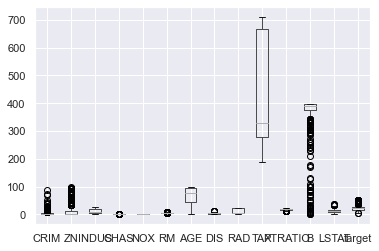

In [8]:
df.boxplot()

In [9]:
from sklearn.preprocessing import MinMaxScaler
# Scale first then boxplot
viz_scaler =  MinMaxScaler()
df_scaled = viz_scaler.fit_transform(df)
df_scaled

array([[0.00000000e+00, 1.80000000e-01, 6.78152493e-02, ...,
        1.00000000e+00, 8.96799117e-02, 4.22222222e-01],
       [2.35922539e-04, 0.00000000e+00, 2.42302053e-01, ...,
        1.00000000e+00, 2.04470199e-01, 3.68888889e-01],
       [2.35697744e-04, 0.00000000e+00, 2.42302053e-01, ...,
        9.89737254e-01, 6.34657837e-02, 6.60000000e-01],
       ...,
       [6.11892474e-04, 0.00000000e+00, 4.20454545e-01, ...,
        1.00000000e+00, 1.07891832e-01, 4.20000000e-01],
       [1.16072990e-03, 0.00000000e+00, 4.20454545e-01, ...,
        9.91300620e-01, 1.31070640e-01, 3.77777778e-01],
       [4.61841693e-04, 0.00000000e+00, 4.20454545e-01, ...,
        1.00000000e+00, 1.69701987e-01, 1.53333333e-01]])

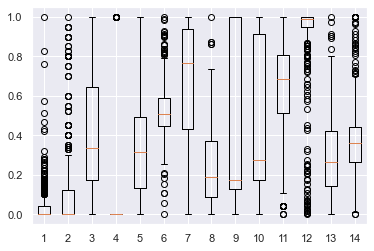

In [10]:
plt.boxplot(df_scaled)
plt.show()

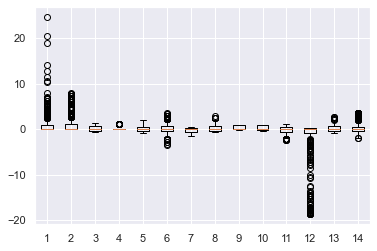

In [11]:
# Majority of the data is not as compressed as before, which is good, but still not very good
from sklearn.preprocessing import RobustScaler
viz_scaler_robust =  RobustScaler()
df_scaled_robust = viz_scaler_robust.fit_transform(df)
plt.boxplot(df_scaled_robust)
plt.show()

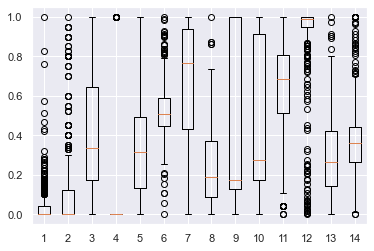

In [12]:
plt.boxplot(df_scaled)
plt.show()

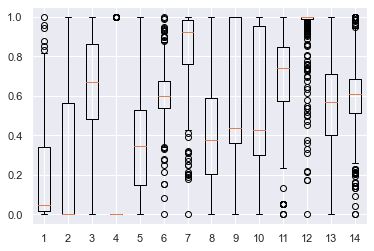

In [13]:
# Log Transform
viz_scaler_log =  MinMaxScaler()
df_scaled_log = viz_scaler_log.fit_transform(np.log1p(df))
plt.boxplot(df_scaled_log)
plt.show()

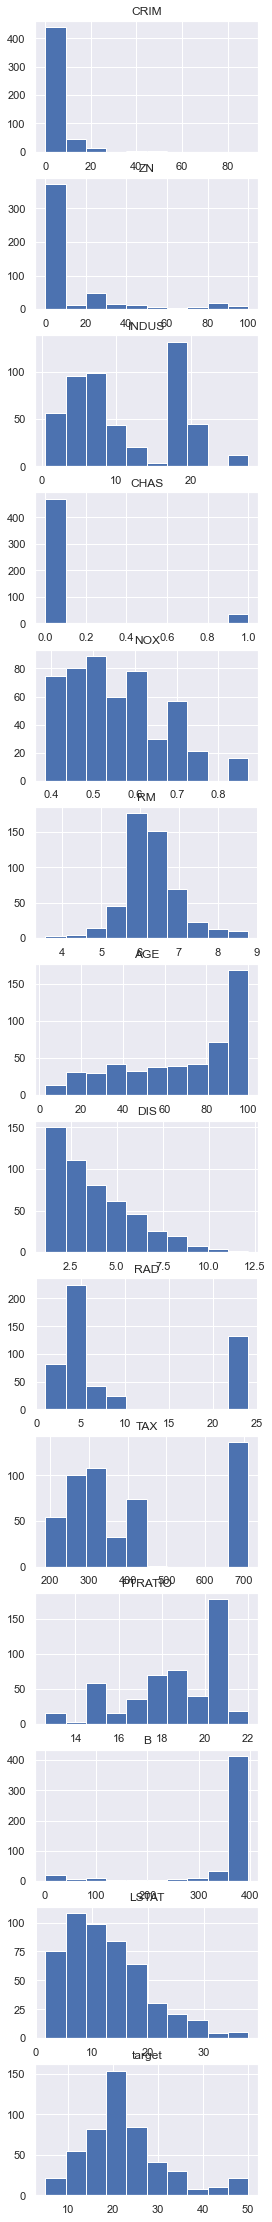

In [14]:
plt.figure(figsize=(4,40))
for i in range(df.shape[1]):
    ax = plt.subplot(df.shape[1],1,i+1)
    ax.hist(df.iloc[:,i])
    ax.set_title(df.columns[i])

In [ ]:
# Log transform: 1,2, 8(ish), 13
# MinMax or Standard: 3,5,6,9,10,11,14 (perhaps above after log transform)
# Don't touch: 4
# subtract from max-val than log transform: 7, 12(may not work well)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #why not stratify=y?

(array([ 15.,  41.,  65., 125.,  73.,  33.,  20.,   8.,   7.,  17.]),
 array([ 5. ,  9.5, 14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. ]),
 <BarContainer object of 10 artists>)

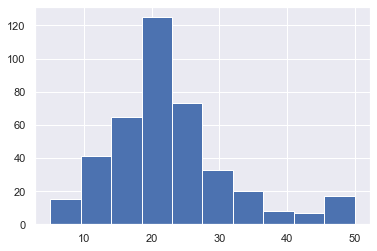

In [18]:
plt.hist(y_train)

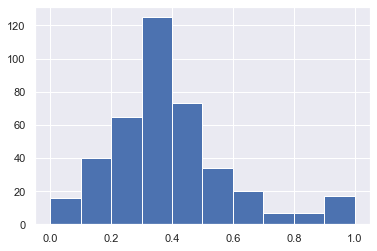

In [16]:
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1,1)).ravel()
y_test_scaled  = target_scaler.transform(y_test.reshape(-1,1)).ravel()

plt.hist(y_train_scaled)
plt.show()

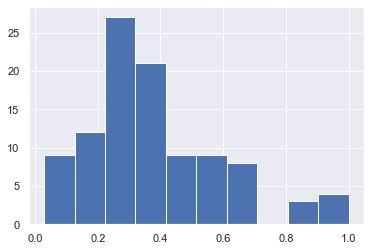

In [19]:
plt.hist(y_test_scaled)
plt.show()

In [20]:
def MaxRevert(input_array):
    return input_array.max(axis=0) - input_array

In [21]:
# Log transform: 1,2,8(ish),13
# MinMax or Standard: 3,5,6,9,10,11,14 (perhaps above after log transform)
# Don't touch: 4
# subtract from max-val than log transform: 7, 12(may not work well)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

LogAndScale = Pipeline(steps=[('log', FunctionTransformer(np.log1p)),
                              ('scale', MinMaxScaler())])

MaxSubtractLogAndScale = Pipeline(steps=[('maxsub',FunctionTransformer(MaxRevert)),
                                         ('log',FunctionTransformer(np.log1p)),
                                         ('scale', MinMaxScaler())])

#0 based indexing
CT = ColumnTransformer([('logscale', LogAndScale, [0,1,7,12]),
                        #('justscale', MinMaxScaler(), [2,4,5,8,9,10]),  #14 is the target
                        ('justscale', MinMaxScaler(), [2,4,8,9,10]),  #14 is the target
                        ('customscale', MinMaxScaler(feature_range=(-0.3,1.3)),[5]),
                        ('keep','passthrough',[3]),
                        ('custom',MaxSubtractLogAndScale,[6,11])])

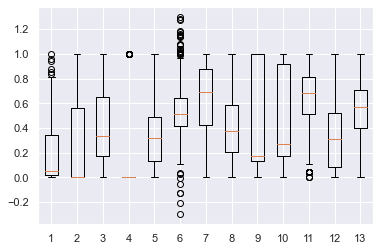

In [22]:
#Just for visualization purposes!

X_transformed = CT.fit_transform(X)

#unscramble = [0,1,4,10,5,6,11,2,7,8,9,12,3]
#unscramble =[0, 1, 7, 12, 2, 4, 5, 8, 9, 10, 3, 6, 11]
unscramble =[0, 1, 7, 12, 2, 4, 8, 9, 10, 5, 3, 6, 11]
idx = np.empty_like(unscramble)
idx[unscramble] = np.arange(len(unscramble))

plt.boxplot(X_transformed[:,idx])
plt.show()

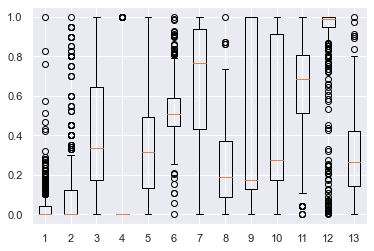

In [23]:
plt.boxplot(df_scaled[:,:13])
plt.show()

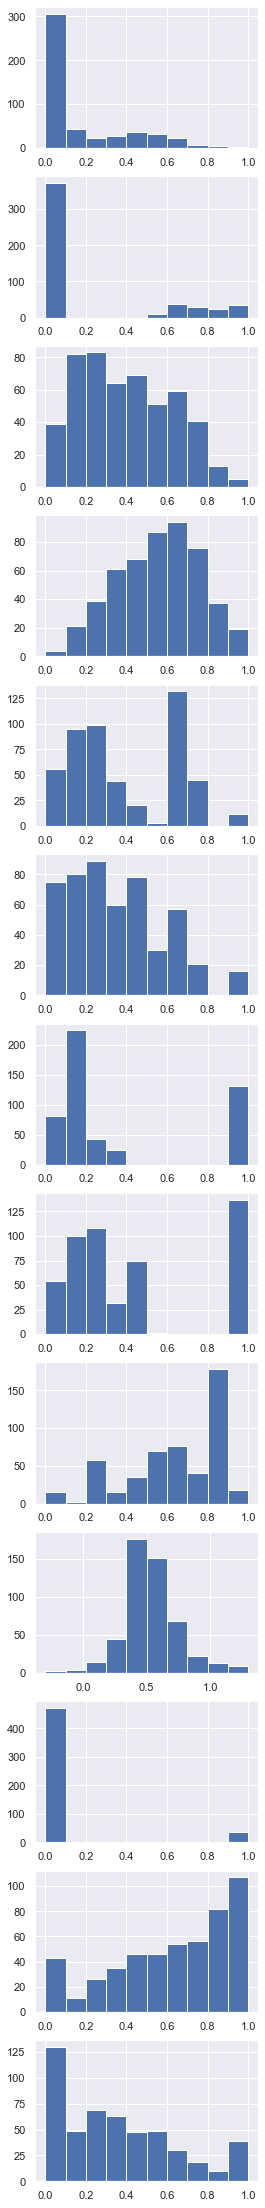

In [24]:
plt.figure(figsize=(4,40))
for i in range(X_transformed.shape[1]):
    ax = plt.subplot(X_transformed.shape[1],1,i+1)
    ax.hist(X_transformed[:,i])

In [25]:
X_train_transformed = CT.fit_transform(X_train)
X_test_transformed = CT.transform(X_test)

In [26]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree  import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

svm = SVR()
lr = LinearRegression()
etr = ExtraTreeRegressor()
rf = RandomForestRegressor()

svm.fit(X_train_transformed, y_train_scaled)
lr.fit(X_train_transformed, y_train_scaled)
etr.fit(X_train_transformed, y_train_scaled)
rf.fit(X_train_transformed, y_train_scaled)

RandomForestRegressor()

In [27]:
yPredSvm = svm.predict(X_test_transformed)
yPredLr  = lr.predict(X_test_transformed)
yPredEtr = etr.predict(X_test_transformed)
yPredRf  = rf.predict(X_test_transformed)

print('SVM:',svm.score(X_test_transformed,y_test_scaled),mean_absolute_error(y_test_scaled,yPredSvm),mean_squared_error(y_test_scaled,yPredSvm))
print('LR: ',lr.score(X_test_transformed,y_test_scaled),mean_absolute_error(y_test_scaled,yPredLr),mean_squared_error(y_test_scaled,yPredLr))
print('ETR:',etr.score(X_test_transformed,y_test_scaled),mean_absolute_error(y_test_scaled,yPredEtr),mean_squared_error(y_test_scaled,yPredEtr))
print('RF: ',rf.score(X_test_transformed,y_test_scaled),mean_absolute_error(y_test_scaled,yPredRf),mean_squared_error(y_test_scaled,yPredRf))

SVM: 0.8814380335199704 0.05570973782301805 0.005502550730820805
LR:  0.8029011455952062 0.07522626988501596 0.009147507228059695
ETR: 0.8288675475563178 0.0619607843137255 0.00794238683127572
RF:  0.8905088780700989 0.051361002178649244 0.005081565959816024


In [28]:
# Compare with just scaling?
svm.fit(X_train, y_train)
lr.fit(X_train, y_train)
etr.fit(X_train, y_train)
rf.fit(X_train, y_train)

yPredSvm = svm.predict(X_test)
yPredLr  = lr.predict(X_test)
yPredEtr = etr.predict(X_test)
yPredRf  = rf.predict(X_test)

print('SVM:',svm.score(X_test,y_test),mean_absolute_error(y_test,yPredSvm),mean_squared_error(y_test,yPredSvm))
print('LR: ',lr.score(X_test,y_test), mean_absolute_error(y_test,yPredLr), mean_squared_error(y_test,yPredLr))
print('ETR:',etr.score(X_test,y_test),mean_absolute_error(y_test,yPredEtr),mean_squared_error(y_test,yPredEtr))
print('RF: ',rf.score(X_test,y_test),mean_absolute_error(y_test,yPredRf),mean_squared_error(y_test,yPredRf))

SVM: 0.31959284409414856 5.589712908676058 63.945878964250795
LR:  0.7885520222195108 3.361402687685145 19.872258363281667
ETR: 0.5479161508971147 3.749019607843137 42.48764705882352
RF:  0.88024147869337 2.364215686274509 11.255119588235289


**Home Exercise:** Re-visit the Auto MPG data from Dasc501